In [41]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
# from qolmat.diffusion_model  import ImputerDiffusion
# from qolmat.model import TabDDPM, TsDDPM
from diffusion import DDPM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from load_data import prepare_data, aggregate_market_data
from models import CustomTransformerTimeSeries
from dataloader import TimeSeriesDataset

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
print(device)

cuda:0


## Load Data

In [44]:
from_year = "1999"
end_year = "2019"
start_year_test = "2020"

In [45]:
data = aggregate_market_data()

df_reindexed, df_orig, df = prepare_data(data, from_year = from_year, start_year_test = None)

100%|██████████| 141/141 [00:00<00:00, 326.08it/s]


### Preprocess Data

In [46]:
train_df = df_reindexed#.loc[:'2019']
train_df = train_df.interpolate(method='nearest')
X_train = train_df.to_numpy()
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
print(X_train.shape)

torch.Size([6390, 53])


## Hyperparameters

In [47]:
# hyperparameters

# diffusion hyperparameters
timesteps = 50
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
input_size = 30
hidden_dim = 32
n_feat = df_reindexed.shape[1] 
save_dir = './weights/'

# training hyperparameters
batch_size = 64
n_epoch = 50
lrate=1e-3

## DDPM

### Models

In [48]:
#model = CustomTransformerTimeSeries(input_size=input_size, n_feat=n_feat, hidden_size=32, num_layers=2, num_heads=2, dropout_prob=0.1)

In [49]:
from models import AutoEncoder, ResidualBlockTS
model = AutoEncoder(num_noise_steps = timesteps,
                    dim_input = n_feat ,
                    residual_block = ResidualBlockTS(hidden_dim, input_size, hidden_dim),
                    dim_embedding = hidden_dim,
                    dim_output = n_feat,
).to(device)

In [50]:
# model_qolmat = TsDDPM(num_noise_steps=50,nheads_feature=8,nheads_time=8)

### Training

In [51]:
train_dataset = TimeSeriesDataset(X_train, seq_len=input_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
optim = torch.optim.Adam(model.parameters(), lr=lrate)

In [52]:
ddpm = DDPM(model = model, 
            optimizer = optim,
            device = device, 
            timesteps = timesteps, 
            beta1 = beta1, 
            beta2 = beta2, 
            n_epoch = n_epoch, 
            batch_size = batch_size, 
            lrate = lrate, 
            save_dir = save_dir)

In [53]:
losses, maes, wasserstein_distances =ddpm.train(train_loader=train_loader)

epoch 0


100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Loss: 1.5682815378531814, MAE: 1.2489949390292168, Wasserstein Distance: 1.1405817086031815
epoch 1


100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


epoch 2


100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


epoch 3


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


epoch 4


100%|██████████| 100/100 [00:03<00:00, 27.72it/s]


Loss: 1.5011515468358994, MAE: 1.2210965733975172, Wasserstein Distance: 1.0465476607622373
epoch 5


100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


epoch 6


100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


epoch 7


100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


epoch 8


100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Loss: 1.4756672661751509, MAE: 1.2095243893563747, Wasserstein Distance: 1.0317803358908373
epoch 9


100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


epoch 10


100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


epoch 11


100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


epoch 12


100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Loss: 1.4698471035808325, MAE: 1.2063208408653736, Wasserstein Distance: 1.0307493170610205
epoch 13


100%|██████████| 100/100 [00:03<00:00, 28.03it/s]


epoch 14


100%|██████████| 100/100 [00:03<00:00, 27.94it/s]


epoch 15


100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


epoch 16


100%|██████████| 100/100 [00:03<00:00, 27.93it/s]


Loss: 1.4589599091559649, MAE: 1.2014097487553954, Wasserstein Distance: 1.016576241751365
epoch 17


100%|██████████| 100/100 [00:03<00:00, 27.93it/s]


epoch 18


100%|██████████| 100/100 [00:03<00:00, 27.86it/s]


epoch 19


100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


epoch 20


100%|██████████| 100/100 [00:03<00:00, 27.91it/s]


Loss: 1.4545506397262216, MAE: 1.1993373446166515, Wasserstein Distance: 1.0137294556122838
epoch 21


100%|██████████| 100/100 [00:03<00:00, 27.91it/s]


epoch 22


100%|██████████| 100/100 [00:03<00:00, 27.87it/s]


epoch 23


100%|██████████| 100/100 [00:03<00:00, 27.93it/s]


epoch 24


100%|██████████| 100/100 [00:03<00:00, 27.88it/s]


Loss: 1.4559658272191882, MAE: 1.1997582409530878, Wasserstein Distance: 1.015634487943943
epoch 25


100%|██████████| 100/100 [00:03<00:00, 27.92it/s]


epoch 26


100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


epoch 27


100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


epoch 28


100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


Loss: 1.4556998973712325, MAE: 1.1997446231544018, Wasserstein Distance: 1.011622589673701
epoch 29


100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


epoch 30


100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


epoch 31


100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


epoch 32


100%|██████████| 100/100 [00:03<00:00, 27.80it/s]


Loss: 1.4476602729409933, MAE: 1.1959600746631622, Wasserstein Distance: 1.0071468650515032
epoch 33


100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


epoch 34


100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


epoch 35


100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


epoch 36


100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


Loss: 1.4500835500657558, MAE: 1.1969043733552098, Wasserstein Distance: 1.0087885612061551
epoch 37


100%|██████████| 100/100 [00:03<00:00, 27.76it/s]


epoch 38


100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


epoch 39


100%|██████████| 100/100 [00:03<00:00, 27.87it/s]


epoch 40


100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


Loss: 1.4475867338478565, MAE: 1.1958426553755999, Wasserstein Distance: 1.006130689185519
epoch 41


100%|██████████| 100/100 [00:03<00:00, 27.92it/s]


epoch 42


100%|██████████| 100/100 [00:03<00:00, 27.88it/s]


epoch 43


100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


epoch 44


100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


Loss: 1.4464501943439245, MAE: 1.1953063132241368, Wasserstein Distance: 1.0071659498016758
epoch 45


100%|██████████| 100/100 [00:03<00:00, 27.86it/s]


epoch 46


100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


epoch 47


100%|██████████| 100/100 [00:03<00:00, 27.81it/s]


epoch 48


100%|██████████| 100/100 [00:03<00:00, 27.89it/s]


Loss: 1.4492212636396289, MAE: 1.1963349943980575, Wasserstein Distance: 1.0110611118871398
epoch 49


100%|██████████| 100/100 [00:03<00:00, 27.87it/s]

Loss: 1.448471711948514, MAE: 1.1962691014632583, Wasserstein Distance: 1.008094841784911
saved model at ./weights/model_final.pth


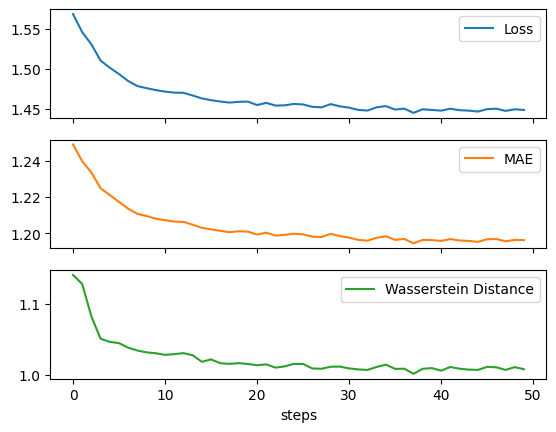

In [54]:
# Convert lists to DataFrame
metrics_df = pd.DataFrame({
    'Loss': losses,
    'MAE': maes,
    'Wasserstein Distance': wasserstein_distances
})

# Plot metrics
metrics_df.plot(subplots=True)
plt.xlabel('steps')
plt.show()

## F-DDPM

epoch 0


100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Loss: 1.557842063717544, MAE: 1.244767028838396, Wasserstein Distance: 1.128048664282576
epoch 1


100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


epoch 2


100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


epoch 3


100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


epoch 4


100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Loss: 1.460075730457902, MAE: 1.2028968632221222, Wasserstein Distance: 1.0007269000740404
epoch 5


100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


epoch 6


100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


epoch 7


100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


epoch 8


100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Loss: 1.436611627228558, MAE: 1.1916990038007498, Wasserstein Distance: 0.9807012377312944
epoch 9


100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


epoch 10


100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


epoch 11


100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


epoch 12


100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Loss: 1.425576912239194, MAE: 1.1862391084432602, Wasserstein Distance: 0.9714091139445057
epoch 13


100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


epoch 14


100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


epoch 15


100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


epoch 16


100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Loss: 1.4169094860553741, MAE: 1.1822887072339654, Wasserstein Distance: 0.9609921818126287
epoch 17


100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


epoch 18


100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


epoch 19


100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


epoch 20


100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Loss: 1.411447063088417, MAE: 1.1796270832419395, Wasserstein Distance: 0.9560712005492801
epoch 21


100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


epoch 22


100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


epoch 23


100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


epoch 24


100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Loss: 1.4155705384910107, MAE: 1.1814889162778854, Wasserstein Distance: 0.9619260188435034
epoch 25


100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


epoch 26


100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


epoch 27


100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


epoch 28


100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Loss: 1.413075595162809, MAE: 1.1803975887596607, Wasserstein Distance: 0.9625721648797224
epoch 29


100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


epoch 30


100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


epoch 31


100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


epoch 32


100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Loss: 1.4096569940447807, MAE: 1.1786595676094294, Wasserstein Distance: 0.9602211438807399
epoch 33


100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


epoch 34


100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


epoch 35


100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


epoch 36


100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Loss: 1.4094305150210857, MAE: 1.1785393906757236, Wasserstein Distance: 0.9601969783769052
epoch 37


100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


epoch 38


100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


epoch 39


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


epoch 40


100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Loss: 1.407742084003985, MAE: 1.1777831623330712, Wasserstein Distance: 0.9567040923836917
epoch 41


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


epoch 42


100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


epoch 43


100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


epoch 44


100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Loss: 1.4051015293225646, MAE: 1.176353326998651, Wasserstein Distance: 0.9551560827115263
epoch 45


100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


epoch 46


100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


epoch 47


100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


epoch 48


100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Loss: 1.4072632575407624, MAE: 1.1774502592161298, Wasserstein Distance: 0.9583786097230533
epoch 49


100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Loss: 1.40653539262712, MAE: 1.1771679082885385, Wasserstein Distance: 0.9552690465791565
saved model at ./weights/model_final.pth


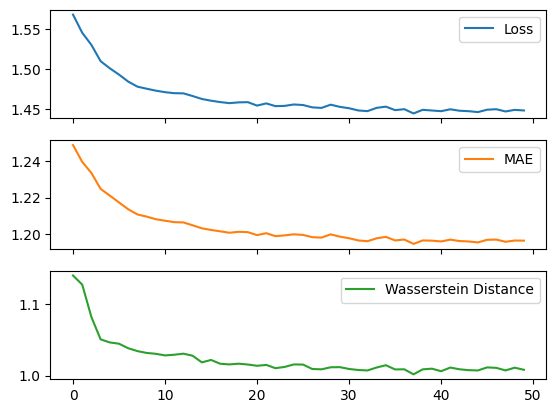

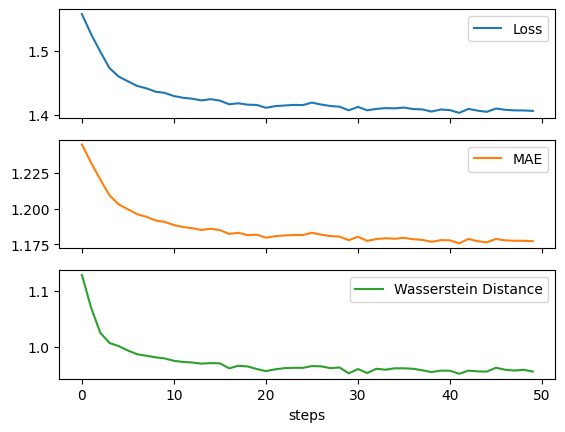

RuntimeError: Parent directory results/f-DDPM/Model does not exist.

In [57]:
from models import AutoEncoder, ResidualBlockTS
from diffusion import F_DDPM

model_f = AutoEncoder(num_noise_steps = timesteps,
                    dim_input = n_feat ,
                    residual_block = ResidualBlockTS(hidden_dim, input_size, hidden_dim),
                    dim_embedding = hidden_dim,
                    dim_output = n_feat ,
).to(device)

train_dataset = TimeSeriesDataset(X_train, seq_len=input_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
optim = torch.optim.Adam(model_f.parameters(), lr=lrate)

f_ddpm = F_DDPM(model = model_f, 
            optimizer = optim,
            device = device, 
            timesteps = timesteps, 
            beta1 = beta1, 
            beta2 = beta2, 
            n_epoch = n_epoch, 
            batch_size = batch_size, 
            lrate = lrate, 
            save_dir = save_dir)

losses, maes, wasserstein_distances = f_ddpm.train(train_loader=train_loader)

# Convert lists to DataFrame
metrics_fddmp_df = pd.DataFrame({
    'Loss': losses,
    'MAE': maes,
    'Wasserstein Distance': wasserstein_distances
})

# Plot two models metrics
metrics_df.plot(subplots=True)
metrics_fddmp_df.plot(subplots=True)
plt.xlabel('steps')
plt.show()

In [79]:
# save model
save_dir = 'results/F-DDPM/Model/'
torch.save(f_ddpm.state_dict(), os.path.join(save_dir, 'model.pt'))

### Training Loss

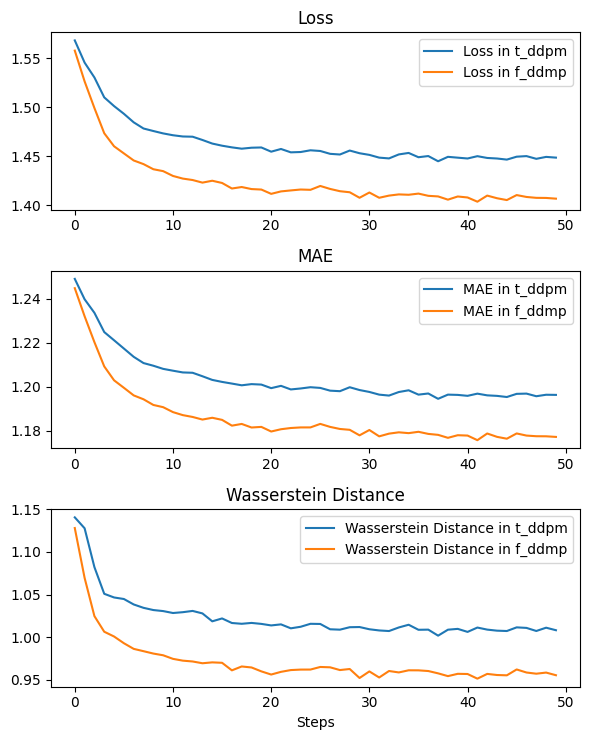

In [61]:
import matplotlib.pyplot as plt

num_plots = len(metrics_df.columns)
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(6, num_plots * 2.5))

if num_plots == 1:
    axes = [axes]

for i, column in enumerate(metrics_df.columns):
    metrics_df[column].plot(ax=axes[i], label=f'{column} in t_ddpm')
    metrics_fddmp_df[column].plot(ax=axes[i], label=f'{column} in f_ddmp')
    axes[i].set_title(column)
    axes[i].legend()

plt.xlabel('Steps')

plt.tight_layout()  
plt.show()

### Load model

In [82]:
f_ddpm = F_DDPM(model=model_f,
                        optimizer=optim,
                        device=device,
                        timesteps=timesteps,
                        beta1=beta1,
                        beta2=beta2,
                        n_epoch=n_epoch,
                        batch_size=batch_size,
                        lrate=lrate,
                        save_dir=save_dir)

f_ddpm.load_state_dict(torch.load('results/F-DDPM/Model/model.pt'))

n_sample = X_train.shape[0] // input_size

gen_samples, _  = f_ddpm.sample(n_sample = n_sample, window_size = input_size, dim_input = n_feat, save_rate=20)

np.save('results/F-DDPM/Model/samples.npy', gen_samples.cpu())

In [19]:
"""tabddpm = ImputerDiffusion(
    model_qolmat, epochs=n_epoch, batch_size=batch_size, x_valid=df_reindexed, print_valid=True,index_datetime='date',
      freq_str = '1B',columnwise=False)"""
#tabddpm.fit(df_reindexed)
#pd.DataFrame(tabddpm.model.summary).plot(subplots=True)
#plt.xlabel('epochs')

"tabddpm = ImputerDiffusion(\n    model_qolmat, epochs=n_epoch, batch_size=batch_size, x_valid=df_reindexed, print_valid=True,index_datetime='date',\n      freq_str = '1B',columnwise=False)"

### Evaluation

In [85]:
# evaluation
from evaluation_metrics import TransformerModel
from evaluation_metrics import evaluate_synthetic_data

n_samples = 100
seq_len = 30

samples_orig = torch.zeros((n_samples, seq_len, n_feat))
for i in range(n_samples):
    idx = np.random.randint(0, X_train.shape[0]-seq_len)
    samples_orig[i] = X_train[idx:idx+seq_len]

start = samples_orig[:, 0, :]
# gen_samples = f_ddpm.sample(start, n_samples, seq_len, n_feat)
gen_samples, _  = f_ddpm.sample(n_sample = n_samples,
                                window_size = input_size,
                                dim_input = n_feat,
                                save_rate=20)

samples_orig = samples_orig.cpu().detach().numpy()
gen_samples = gen_samples.cpu().detach().numpy()

eval_model_d = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='classification')
eval_model_p = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='regression')
eval_results = evaluate_synthetic_data(eval_model_d, eval_model_p, gen_samples, samples_orig, train_ratio=0.8)
print(eval_results)

# save samples
save_dir = 'results/F-DDPM/Model/'
np.save(os.path.join(save_dir, 'samples.npy'), gen_samples)

Training LDS model...
Epoch [1/10], Loss: 0.10684040933847427
Epoch [2/10], Loss: 0.09730502404272556
Epoch [3/10], Loss: 0.09143990464508533
Epoch [4/10], Loss: 0.08572770841419697


/Data/.sys/envs/env0/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [5/10], Loss: 0.07858892530202866
Epoch [6/10], Loss: 0.07405404932796955
Epoch [7/10], Loss: 0.0671771988272667
Epoch [8/10], Loss: 0.059714678674936295
Epoch [9/10], Loss: 0.05237516853958368
Epoch [10/10], Loss: 0.04632556950673461
Training LPS model...
Epoch [1/20], Loss: 3.952881336212158
Epoch [2/20], Loss: 3.822496771812439
Epoch [3/20], Loss: 3.671415627002716
Epoch [4/20], Loss: 3.7773207426071167
Epoch [5/20], Loss: 3.644571840763092
Epoch [6/20], Loss: 3.5884976387023926
Epoch [7/20], Loss: 3.5506709218025208
Epoch [8/20], Loss: 3.553356111049652
Epoch [9/20], Loss: 3.418615400791168
Epoch [10/20], Loss: 3.3249817490577698
Epoch [11/20], Loss: 3.499017298221588
Epoch [12/20], Loss: 3.282974898815155
Epoch [13/20], Loss: 3.3132447004318237
Epoch [14/20], Loss: 3.374991536140442
Epoch [15/20], Loss: 3.3419567942619324
Epoch [16/20], Loss: 3.299169182777405
Epoch [17/20], Loss: 3.4285025000572205
Epoch [18/20], Loss: 3.2741106152534485
Epoch [19/20], Loss: 3.1968701481819

In [ ]:
import json
from evaluation_metrics import TransformerModel
from evaluation_metrics import evaluate_synthetic_data
path_results = os.getcwd() + "/results/F-DDPM/"
# path_results = os.getcwd() + "\\100\\"
parameters = [d for d in os.listdir(path_results) if os.path.isdir(os.path.join(path_results, d))]
print(parameters)
for param in parameters:
    print(param)
    path_parameters = path_results + param
    var = [d for d in os.listdir(path_parameters) if os.path.isdir(os.path.join(path_parameters, d))]
    print(var)
    train_ratio = 0.8
    results = {}
    for v in var:
        print(v)
        config_results = json.load(open(path_parameters + "/" + v + '/config.json', 'r'))
        #create  samples from df_orig time series
        seq_len = config_results["SEQ_LEN"]
        n_samples = X_train.shape[0] // seq_len
        samples_orig = np.zeros((n_samples, seq_len, n_feat))
        for i in range(n_samples):
            idx = np.random.randint(0, df_orig.shape[0]-seq_len)
            samples_orig[i] = df_orig.iloc[idx:idx+seq_len].values

        gen_samples = np.load(path_parameters + "/" + v + '/samples.npy')[:n_samples]
        eval_model_d = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='classification')
        eval_model_p = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='regression')
        eval_results = evaluate_synthetic_data(eval_model_d, eval_model_p, gen_samples, samples_orig, train_ratio=train_ratio)
        results[v] = eval_results    
    results_df = pd.DataFrame(results).T
    results_df.index = results_df.index.astype(float)
    results_df = results_df.sort_index()
    results_df.index.name = param
    results_df.plot(subplots=True, figsize=(10, 8), linewidth=2, marker='o')
    plt.xticks(results_df.index)
    plt.savefig('./plots/' + param + '_epoch_300_timesteps_100'+'.png')

#### Visualisations

In [28]:
df_orig = df_orig['Ret'].unstack().T

In [29]:
synth_data = gen_samples.reshape(-1, gen_samples.shape[2]).shape

In [ ]:
synth_data = pd.DataFrame(gen_samples[0,:,:].numpy(), index=df_orig[start_year_test:].index[:input_size], columns=df_orig.columns)

In [31]:
from plot_results import plot_data

In [ ]:
columns = df_orig.columns.tolist()
starting_point = df_orig[:end_year].cumsum().dropna().iloc[-1]
plot_data(df_orig, synth_data, starting_point, columns[:10])

In [33]:
from evaluation_metrics import kl_divergence_columns, kl_divergence_rows, wasserstein_distance_columns, wasserstein_distance_rows, compute_frobenius_norm, compute_condition_number, compute_spectral_norm

In [34]:
true_data = df_orig[start_year_test:]

In [ ]:
kl_col = kl_divergence_columns(synth_data,true_data)
kl_rows = kl_divergence_rows(synth_data,true_data)
wasserstein_col = wasserstein_distance_columns(synth_data,true_data)
wasserstein_rows = wasserstein_distance_rows(synth_data,true_data)


In [ ]:
kl_col.mean().values[0]

In [ ]:

fig,axes = plt.subplots(nrows=4,ncols = 1,figsize = (15,15))
metrics = [kl_col,kl_rows,wasserstein_col, wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)


In [ ]:
synth_data.cumsum().sum(1).plot(label = 'total return synthetic data')
true_data.cumsum().sum(1).plot(label = 'total return true data')
plt.legend()

In [ ]:
cov_matrix_true = np.cov(true_data, rowvar=False)
cov_matrix_synthetic = np.cov(synthetic_data, rowvar=False)


# Calculate metrics
frobenius_norm = compute_frobenius_norm(cov_matrix_true, cov_matrix_synthetic)
spectral_norm = compute_spectral_norm(cov_matrix_true, cov_matrix_synthetic)
condition_number_true = compute_condition_number(cov_matrix_true)
condition_number_synthetic = compute_condition_number(cov_matrix_synthetic)

# Print metrics
print(f"Frobenius Norm: {frobenius_norm}")
print(f"Spectral Norm: {spectral_norm}")
print(f"Condition Number - True Data: {condition_number_true}")
print(f"Condition Number - Synthetic Data: {condition_number_synthetic}")



In [ ]:
from plot_results import plot_covariance_matrices, plot_eigenvalues
# Plot covariance matrices
plot_covariance_matrices(cov_matrix_true, cov_matrix_synthetic)


In [ ]:
from evaluation_metrics import eigen_decomposition
from plot_results import plot_eigenvalues
# Eigenvalue decomposition
eigenvalues_true, eigenvectors_true = eigen_decomposition(cov_matrix_true)
eigenvalues_synthetic, eigenvectors_synthetic = eigen_decomposition(cov_matrix_synthetic)

# Plot eigenvalues
plot_eigenvalues(eigenvalues_true, eigenvalues_synthetic)


In [ ]:
from evaluation_metrics import compute_principal_components, project_onto_principal_components
from plot_results import plot_projection_on_principal_components


# Compute principal components from true data
_, eigenvectors_true = compute_principal_components(true_data)

# Project both true and synthetic data onto these principal components
projection_true = project_onto_principal_components(true_data, eigenvectors_true)
projection_synthetic = project_onto_principal_components(synth_data, eigenvectors_true)

# Visualize the projections
plot_projection_on_principal_components(projection_true, projection_synthetic)
